In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


### Load data and divide into train and test set:

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "segmented_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
labels = []
image_paths = []
for key, item in list(image_dict.items()):
    for image_path in item:
        labels.append(list(image_dict.keys()).index(key))
        image_paths.append(image_path)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=205)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=205)
print(len(X_train), len(X_val), len(X_test))
print(*image_dict.keys(), sep=', ')

1641 411 514
Astrocitoma, Carcinoma, Ependimoma, Glioblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, _NORMAL


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_path, image_paths, labels, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_paths = image_paths
        self.image_class_list = labels
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_class_list)

    def __getitem__(self, idx):
        label = self.image_class_list[idx]
        img_path = os.path.join(self.data_path, self.image_paths[idx])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

### AlexNet

#### Hyperparameters set

In [4]:
learning_rate = 1e-3
batch_size = 32
freeze_epochs = 150
unfreeze_epochs = 800
n_classes = len(image_dict.keys())

#### Image augmentation

In [5]:
training_transform = transforms.Compose([transforms.ToTensor(),
                                   #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                   transforms.RandomRotation(45),
                                   transforms.RandomHorizontalFlip(p=0.5)])

#### Load dataset into Dataloaders

Feature batch shape: torch.Size([32, 1, 256, 256])
Labels batch shape: torch.Size([32])


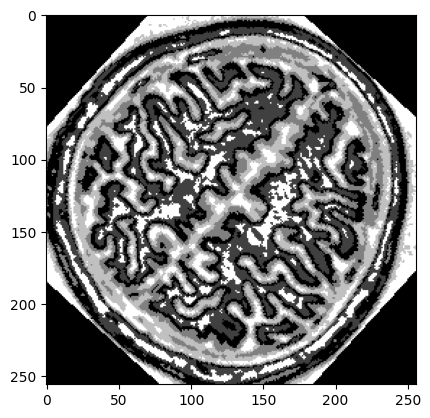

Label: 9


In [6]:
train_dataset = BrainTumorDataset(data_path, X_train, y_train, transform=training_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(data_path, X_test, y_test, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = BrainTumorDataset(data_path, X_val, y_val, transform=transforms.ToTensor())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Load model and modify

In [7]:
model = torchvision.models.alexnet(pretrained=True)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = nn.Sequential(model, nn.Sequential(nn.ReLU(),
                                   nn.Linear(1000, n_classes)))
model

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): L

#### Training loop

#### Freeze

In [8]:
# Freeze CNN layers
for param in model[0].parameters():
    param.requires_grad = False

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Training loss: 2.975282, validation loss: 0.733050
Time elapsed: 6.255731105804443
------------ Epoch: 1 ------------
Training loss: 2.936370, validation loss: 0.735202
Time elapsed: 4.788241863250732
------------ Epoch: 2 ------------
Training loss: 2.926697, validation loss: 0.738319
Time elapsed: 4.958629131317139
------------ Epoch: 3 ------------
Training loss: 2.931336, validation loss: 0.734234
Time elapsed: 4.863112449645996
------------ Epoch: 4 ------------
Training loss: 2.930460, validation loss: 0.745237
Time elapsed: 4.95858097076416
------------ Epoch: 5 ------------
Training loss: 2.934395, validation loss: 0.739250
Time elapsed: 4.726473808288574
------------ Epoch: 6 ------------
Training loss: 2.949664, validation loss: 0.724313
Time elapsed: 4.564110517501831
------------ Epoch: 7 ------------
Training loss: 2.928967, validation loss: 0.731388
Time elapsed: 4.7923219203948975
------------ Epoch: 8 ------------
Training loss: 2.9238

Text(0.5, 0, 'Epoch')

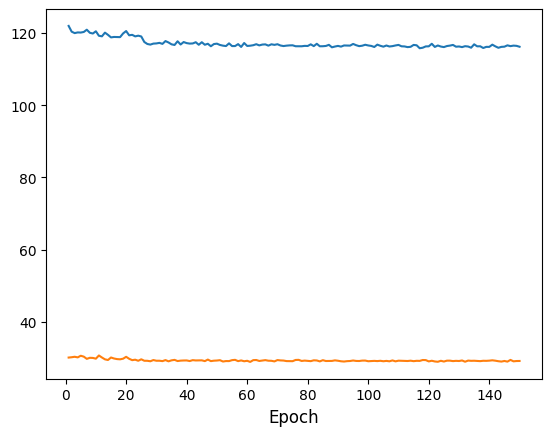

In [9]:
model.to(device)
all_loss = []
all_valid_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.25)
for epoch in range(freeze_epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        #print(loss)
        training_loss += loss
    
    for batch, (X, y) in enumerate(val_dataloader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        valid_loss += loss.item()
        
    scheduler.step()    
    print(f"Training loss: {training_loss/41:>7f}, validation loss: {valid_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, freeze_epochs+1), all_loss)
plt.plot(range(1, freeze_epochs+1), all_valid_loss)
plt.xlabel('Epoch', fontsize=12)

#### Unfreeze

In [10]:
# Freeze CNN layers
for param in model[0].parameters():
    param.requires_grad = True

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Training loss: 2.906041, validation loss: 0.715401
Time elapsed: 9.477577924728394
------------ Epoch: 1 ------------
Training loss: 2.865868, validation loss: 0.707027
Time elapsed: 9.516121625900269
------------ Epoch: 2 ------------
Training loss: 2.850086, validation loss: 0.713235
Time elapsed: 9.279468774795532
------------ Epoch: 3 ------------
Training loss: 2.842593, validation loss: 0.702480
Time elapsed: 9.094390630722046
------------ Epoch: 4 ------------
Training loss: 2.809547, validation loss: 0.723135
Time elapsed: 9.705666542053223
------------ Epoch: 5 ------------
Training loss: 2.816187, validation loss: 0.702010
Time elapsed: 9.384793996810913
------------ Epoch: 6 ------------
Training loss: 2.794052, validation loss: 0.709888
Time elapsed: 9.415603160858154
------------ Epoch: 7 ------------
Training loss: 2.823837, validation loss: 0.683379
Time elapsed: 9.284629583358765
------------ Epoch: 8 ------------
Training loss: 2.7913

Text(0.5, 0, 'Epoch')

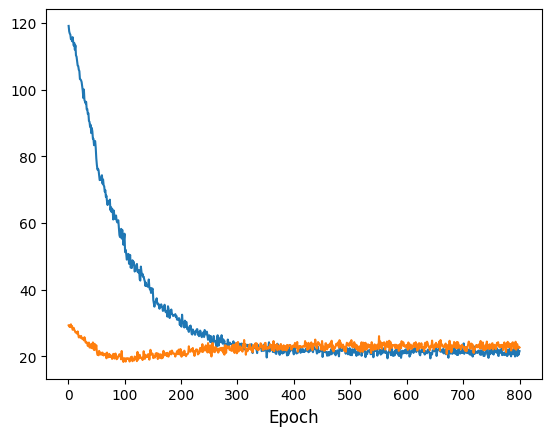

In [11]:
model.to(device)
all_loss = []
all_valid_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
for epoch in range(unfreeze_epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        #print(loss)
        training_loss += loss
    
    for batch, (X, y) in enumerate(val_dataloader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        valid_loss += loss.item()
        
    scheduler.step()    
    print(f"Training loss: {training_loss/41:>7f}, validation loss: {valid_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, unfreeze_epochs+1), all_loss)
plt.plot(range(1, unfreeze_epochs+1), all_valid_loss)
plt.xlabel('Epoch', fontsize=12)

#### Evaluation:

              precision    recall  f1-score   support

           0       0.38      0.42      0.40        59
           1       0.74      0.73      0.74        44
           2       0.26      0.17      0.21        29
           3       0.45      0.47      0.46        36
           4       0.51      0.48      0.49        71
           5       0.71      0.58      0.64        67
           6       0.41      0.53      0.46        34
           7       0.50      0.55      0.53        47
           8       0.65      0.64      0.64        58
           9       0.59      0.64      0.62        69

    accuracy                           0.54       514
   macro avg       0.52      0.52      0.52       514
weighted avg       0.54      0.54      0.54       514



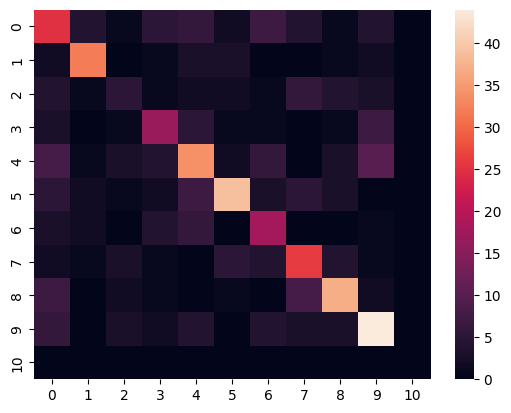

In [12]:
model.to('cpu')
predictions, labels = [], []
for batch, (X, y) in enumerate(test_dataloader):
    # Compute prediction and loss
    pred = torch.argmax(model(X), dim=1)
    #print(pred)
    predictions += pred.tolist()
    labels += y.tolist()

sns.heatmap(confusion_matrix(labels, predictions, labels=range(0, 11)))
print(classification_report(labels, predictions, zero_division=1))